In [246]:
import torch
import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
import torch.nn as nn
from torchvision.models.detection.ssdlite import SSDLiteHead, SSDLiteClassificationHead
from torchvision.datasets import CocoDetection
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm 
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
class CocoDetectionA(CocoDetection):
    def __init__(self, root, annFile, transforms=None):
        super(CocoDetectionA, self).__init__(root, annFile)
        self.transforms = transforms  # Albumentations pipeline

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img = self._load_image(img_id) 

        H0, W0 = img.size[1], img.size[0]  
        bboxes = []
        for obj in anns:
            x, y, w, h = obj["bbox"]
            x_min = x / W0
            y_min = y / H0
            x_max = (x + w) / W0
            y_max = (y + h) / H0
            bboxes.append([x_min, y_min, x_max, y_max])

        labels = [1] * len(bboxes)
        if self.transforms:
            transformed = self.transforms(
                image=np.array(img),
                bboxes=bboxes,
                labels=labels
            )
            img = transformed["image"]
            bboxes = transformed["bboxes"]
            labels = transformed["labels"]

        H, W = img.shape[1], img.shape[2] 
        boxes = []
        for (x_min, y_min, x_max, y_max) in bboxes:
            x1 = x_min * W
            y1 = y_min * H
            x2 = x_max * W
            y2 = y_max * H
            boxes.append([x1, y1, x2, y2])

        if len(boxes) == 0:
            target = {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros((0,), dtype=torch.int64)
            }
        else:
            target = {
                "boxes": torch.as_tensor(boxes, dtype=torch.float32),
                "labels": torch.as_tensor([1] * len(boxes), dtype=torch.int64)
            }

        assert isinstance(target["labels"], torch.Tensor), f"labels is {type(target['labels'])}"
        assert target["labels"].dtype == torch.int64, f"labels dtype: {target['labels'].dtype}"

        img = img.float()

        return img, target


In [ ]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Resize(300, 300),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(
        format='albumentations',  
        label_fields=['labels'],
        min_visibility=0.2,
        check_each_transform=False,
        clip=True
))

val_aug = A.Compose([
    A.Resize(300, 300),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(
        format='albumentations',
        label_fields=['labels'],
        check_each_transform=False,
        clip=True
))


In [ ]:
# Loading the images with the new annotations we did
train_dataset = CocoDetectionA(
    root="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/train",
    annFile="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/train/_annotations.coco.json",
    transforms=train_aug
)

val_dataset = CocoDetectionA(
    root="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/valid",
    annFile="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/valid/_annotations.coco.json",
    transforms=val_aug
)

test_dataset = CocoDetectionA(
    root="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/test",
    annFile="/Users/farahalhanaya/computer-vision-project-mawqif/Dataset/test/_annotations.coco.json",
    transforms=val_aug
)

# This will give us the image as a Tensor [3,H,W], each image with the three channels with the hight and width
# Our target wich is the bounding boxes with the class (Car)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [162]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [163]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=collate_fn, 
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=2, 
    shuffle=False, 
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,     
    shuffle=False,    
    collate_fn=collate_fn
)

In [164]:
anns = train_dataset.coco.loadAnns(train_dataset.coco.getAnnIds(imgIds=train_dataset.ids[0]))
print(anns[0]["bbox"])


[433, 444, 154.35, 140.77]


In [165]:
img, target = train_dataset[0]
print("Image shape:", img.shape)
print("Target:", target)


Image shape: torch.Size([3, 300, 300])
Target: {'boxes': tensor([[1.2686e+02, 1.3008e+02, 1.7208e+02, 1.7132e+02],
        [2.0186e+02, 1.8545e+02, 2.2969e+02, 2.7315e+02],
        [2.5459e+02, 1.8486e+02, 2.8242e+02, 2.7256e+02],
        [8.3496e+01, 1.8252e+02, 1.1133e+02, 2.7022e+02],
        [2.0098e+02, 2.2266e+01, 2.2583e+02, 1.0748e+02],
        [2.2559e+02, 2.0215e+01, 2.4579e+02, 9.9636e+01],
        [3.7207e+01, 2.0186e+02, 6.5042e+01, 2.8094e+02],
        [5.8301e+01, 1.9951e+02, 8.6136e+01, 2.7767e+02],
        [0.0000e+00, 2.0244e+02, 2.7835e+01, 2.9014e+02],
        [1.7520e+02, 2.7275e+02, 2.0303e+02, 2.9980e+02],
        [2.0332e+02, 2.7305e+02, 2.3116e+02, 3.0000e+02],
        [2.7217e+02, 2.7305e+02, 3.0000e+02, 3.0000e+02],
        [3.8086e+01, 2.8154e+02, 6.5921e+01, 3.0000e+02],
        [1.0371e+02, 2.4902e+01, 1.3117e+02, 9.7734e+01],
        [8.0566e+01, 2.6660e+01, 1.0517e+02, 9.9434e+01],
        [6.1523e+01, 3.1934e+01, 8.6124e+01, 1.0471e+02],
        [4.2188

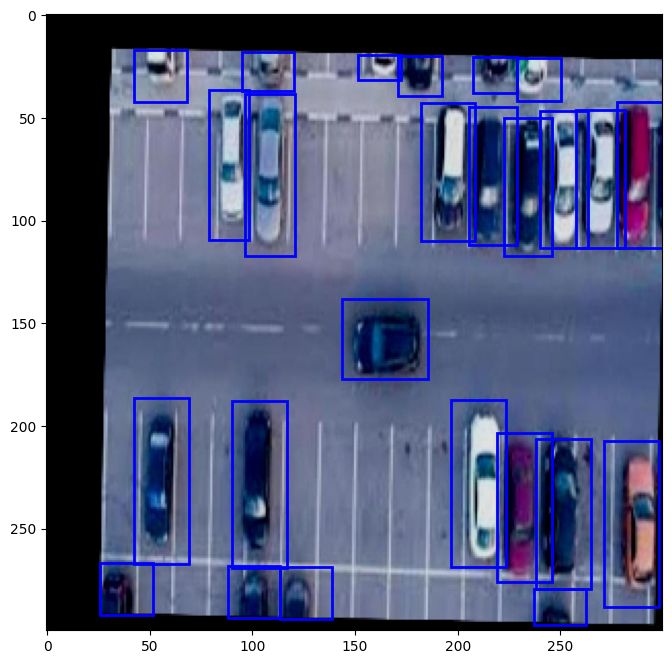

In [ ]:
def denormalize(img_tensor):
    # mean and std used in A.Normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    img = img_tensor.clone()
    img = img * std + mean   # undo normalization so the image looks claer 
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  
    return img

img, target = train_dataset[0]
img_np = denormalize(img)

plt.figure(figsize=(8,8))
plt.imshow(img_np)
for (x1,y1,x2,y2) in target["boxes"]:
    rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor="blue", facecolor="none")
    plt.gca().add_patch(rect)
plt.show()


In [ ]:
# Loading the pretrained model (mobileNet v3 )
model = ssdlite320_mobilenet_v3_large(weights="DEFAULT")

# Replace classification head (we tweaked the head so the model expects 2 classes instead of the original 91 classes)
num_classes = 2  # background + car

# Copy anchor counts from pretrained head
old_head = model.head.classification_head
in_channels = []
num_anchors = []
for m in old_head.module_list:
    conv = m[1]   
    in_channels.append(conv.in_channels)
    num_anchors.append(conv.out_channels // 91) 

# Rebuild head
new_head = SSDLiteClassificationHead(in_channels, num_anchors, num_classes, norm_layer=torch.nn.BatchNorm2d)
model.head.classification_head = new_head


In [174]:
images, targets = next(iter(train_loader))
loss_dict = model(images, targets)
print(loss_dict)


{'bbox_regression': tensor(3.7707, grad_fn=<DivBackward0>), 'classification': tensor(5.2487, grad_fn=<DivBackward0>)}


In [175]:
print(model.head.classification_head)


SSDLiteClassificationHead(
  (module_list): ModuleList(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(672, 672, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=672, bias=False)
        (1): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(672, 12, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(480, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=480, bias=False)
        (1): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(480, 12, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512, bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

In [176]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)


In [ ]:
# Reduce LR every 10 epochs by factor of 0.1
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, targets in loop:
        images = list(img for img in images)   # list of tensors
        targets = list(t for t in targets)     # list of dicts

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        loop.set_postfix(loss=losses.item())

    lr_scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {epoch_loss:.4f}")


Epoch 1/30: 100%|██████████| 109/109 [02:35<00:00,  1.43s/batch, loss=3.59]


Epoch 1/30, Total Loss: 506.4180


Epoch 2/30: 100%|██████████| 109/109 [01:49<00:00,  1.00s/batch, loss=3.08]


Epoch 2/30, Total Loss: 391.3238


Epoch 3/30: 100%|██████████| 109/109 [02:09<00:00,  1.18s/batch, loss=1.97]


Epoch 3/30, Total Loss: 368.0964


Epoch 4/30: 100%|██████████| 109/109 [01:48<00:00,  1.00batch/s, loss=2.82]


Epoch 4/30, Total Loss: 356.7323


Epoch 5/30: 100%|██████████| 109/109 [01:49<00:00,  1.00s/batch, loss=2.41]


Epoch 5/30, Total Loss: 335.6150


Epoch 6/30: 100%|██████████| 109/109 [01:52<00:00,  1.03s/batch, loss=1.68]


Epoch 6/30, Total Loss: 338.2330


Epoch 7/30: 100%|██████████| 109/109 [01:50<00:00,  1.01s/batch, loss=3.1] 


Epoch 7/30, Total Loss: 335.1375


Epoch 8/30: 100%|██████████| 109/109 [01:51<00:00,  1.03s/batch, loss=3.05]


Epoch 8/30, Total Loss: 325.2347


Epoch 9/30: 100%|██████████| 109/109 [01:54<00:00,  1.05s/batch, loss=3.38]


Epoch 9/30, Total Loss: 312.0868


Epoch 10/30: 100%|██████████| 109/109 [01:52<00:00,  1.03s/batch, loss=2.01]


Epoch 10/30, Total Loss: 311.2627


Epoch 11/30: 100%|██████████| 109/109 [01:52<00:00,  1.03s/batch, loss=3.2] 


Epoch 11/30, Total Loss: 312.4072


Epoch 12/30: 100%|██████████| 109/109 [02:44<00:00,  1.51s/batch, loss=2.33]


Epoch 12/30, Total Loss: 315.1188


Epoch 13/30: 100%|██████████| 109/109 [02:02<00:00,  1.13s/batch, loss=2.07]


Epoch 13/30, Total Loss: 311.2171


Epoch 14/30: 100%|██████████| 109/109 [02:03<00:00,  1.14s/batch, loss=3.61]


Epoch 14/30, Total Loss: 308.7459


Epoch 15/30: 100%|██████████| 109/109 [02:29<00:00,  1.38s/batch, loss=3.71]


Epoch 15/30, Total Loss: 309.1474


Epoch 16/30: 100%|██████████| 109/109 [02:18<00:00,  1.27s/batch, loss=1.7] 


Epoch 16/30, Total Loss: 298.0552


Epoch 17/30: 100%|██████████| 109/109 [02:05<00:00,  1.15s/batch, loss=2.6] 


Epoch 17/30, Total Loss: 309.3664


Epoch 18/30: 100%|██████████| 109/109 [02:08<00:00,  1.18s/batch, loss=3.03]


Epoch 18/30, Total Loss: 305.7738


Epoch 19/30: 100%|██████████| 109/109 [02:05<00:00,  1.15s/batch, loss=2.76]


Epoch 19/30, Total Loss: 299.1256


Epoch 20/30: 100%|██████████| 109/109 [02:24<00:00,  1.33s/batch, loss=4.99]


Epoch 20/30, Total Loss: 303.2107


Epoch 21/30: 100%|██████████| 109/109 [02:30<00:00,  1.38s/batch, loss=3.78]


Epoch 21/30, Total Loss: 301.9758


Epoch 22/30: 100%|██████████| 109/109 [02:30<00:00,  1.38s/batch, loss=2.3] 


Epoch 22/30, Total Loss: 302.4767


Epoch 23/30: 100%|██████████| 109/109 [02:12<00:00,  1.21s/batch, loss=2.2] 


Epoch 23/30, Total Loss: 298.5994


Epoch 24/30: 100%|██████████| 109/109 [02:24<00:00,  1.33s/batch, loss=2.07]


Epoch 24/30, Total Loss: 302.4937


Epoch 25/30: 100%|██████████| 109/109 [02:05<00:00,  1.15s/batch, loss=2]   


Epoch 25/30, Total Loss: 296.6415


Epoch 26/30: 100%|██████████| 109/109 [02:07<00:00,  1.17s/batch, loss=3.04]


Epoch 26/30, Total Loss: 304.8238


Epoch 27/30: 100%|██████████| 109/109 [01:53<00:00,  1.04s/batch, loss=2.3] 


Epoch 27/30, Total Loss: 295.2931


Epoch 28/30: 100%|██████████| 109/109 [01:54<00:00,  1.05s/batch, loss=2.31]


Epoch 28/30, Total Loss: 301.9506


Epoch 29/30: 100%|██████████| 109/109 [01:51<00:00,  1.02s/batch, loss=3.14]


Epoch 29/30, Total Loss: 304.6422


Epoch 30/30: 100%|██████████| 109/109 [02:05<00:00,  1.16s/batch, loss=3.69]

Epoch 30/30, Total Loss: 298.0094


In [ ]:
def evaluate_model(model, dataloader, device="cpu", iou_thresh=0.5, score_thresh=0.5):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)  

            for output, target in zip(outputs, targets):
                true_labels = target["labels"].tolist()
                pred_labels = []

                for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                    if score >= score_thresh:  
                        pred_labels.append(int(label.item()))

                y_true.append(1 if len(true_labels) > 0 else 0)
                y_pred.append(1 if len(pred_labels) > 0 else 0)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Car", "Car"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return cm


Validation Set Evaluation


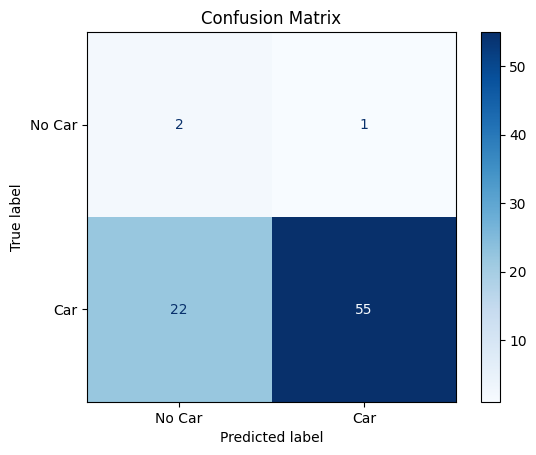

Test Set Evaluation


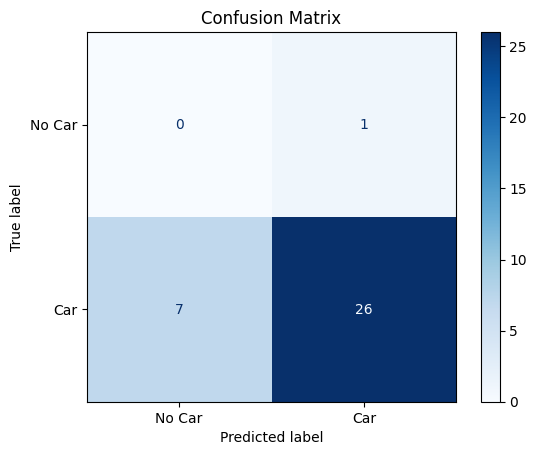

In [180]:
print("Validation Set Evaluation")
cm_val = evaluate_model(model, val_loader, device="cpu")

print("Test Set Evaluation")
cm_test = evaluate_model(model, test_loader, device="cpu")


In [221]:
def unnormalize(img_tensor):
    """Convert normalized tensor [C,H,W] back to uint8 [H,W,C]."""
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # [H,W,C]
    img = (img * 255).clip(0, 255).astype("uint8")
    return img

def plot_predictions(img_tensor, target, preds=None, score_thresh=0.5):
    """
    img_tensor: torch.Tensor [3,H,W]
    target: dict with 'boxes', 'labels' (ground truth)
    preds: dict with 'boxes', 'labels', 'scores' (predictions)
    """
    img = unnormalize(img_tensor)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(img)

    # Draw ground-truth boxes (red)
    for box in target["boxes"]:
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)

    # Draw predicted boxes (green)
    if preds is not None:
        for box, score in zip(preds["boxes"], preds["scores"]):
            if score >= score_thresh:
                x1, y1, x2, y2 = box.tolist()
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    linewidth=2, edgecolor="green", facecolor="none"
                )
                ax.add_patch(rect)
                ax.text(x1, y1-5, f"Car {score:.2f}", color="green", fontsize=8)

    plt.show()

In [229]:
model.eval()
images, targets = next(iter(test_loader))
images = list(img for img in images)

with torch.no_grad():
    mobilenet_preds = model(images)

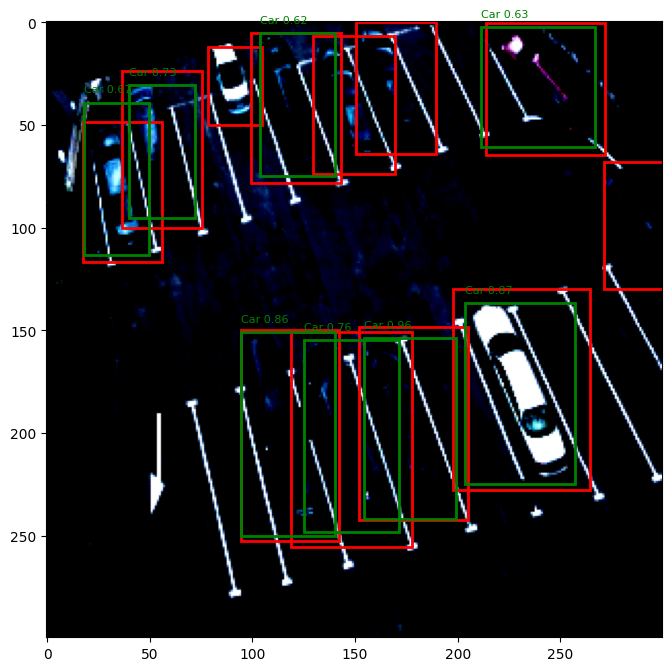

In [231]:
# The red boxes represents the ground truth while the green boxes represents the model's predection
plot_predictions(images[0], targets[0], mobilenet_preds[0], score_thresh=0.6)


# Trying out the R-CNN 

In [194]:
model_rcnn = fasterrcnn_resnet50_fpn(weights="DEFAULT")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/farahalhanaya/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:06<00:00, 24.1MB/s] 


In [195]:
num_classes = 2  # background + car
in_features = model_rcnn.roi_heads.box_predictor.cls_score.in_features
model_rcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes
)


In [196]:
params = [p for p in model_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, 
    lr=0.005, 
    momentum=0.9, 
    weight_decay=0.0005
)


In [197]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.1
)


In [ ]:
num_epochs = 5 
for epoch in range(num_epochs):

    model_rcnn.train()
    train_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, targets in loop:
        images = list(img for img in images)
        targets = list(t for t in targets)

        loss_dict = model_rcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        loop.set_postfix(loss=losses.item())

    model_rcnn.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img for img in images)
            targets = list(t for t in targets)

            
            loss_dict = model_rcnn(images, targets)

            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()
            else:
                # skip batch if detections are returned instead of losses
                continue

    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/5: 100%|██████████| 109/109 [19:32<00:00, 10.75s/batch, loss=0.427]


Epoch 1/5 | Train Loss: 79.8720 | Val Loss: 0.0000


Epoch 2/5: 100%|██████████| 109/109 [19:31<00:00, 10.74s/batch, loss=0.824]


Epoch 2/5 | Train Loss: 72.9470 | Val Loss: 0.0000


Epoch 3/5: 100%|██████████| 109/109 [18:54<00:00, 10.41s/batch, loss=0.602]


Epoch 3/5 | Train Loss: 71.0863 | Val Loss: 0.0000


Epoch 4/5: 100%|██████████| 109/109 [19:31<00:00, 10.75s/batch, loss=0.538]


Epoch 4/5 | Train Loss: 68.8672 | Val Loss: 0.0000


Epoch 5/5: 100%|██████████| 109/109 [18:30<00:00, 10.19s/batch, loss=0.459]


Epoch 5/5 | Train Loss: 68.0201 | Val Loss: 0.0000


In [215]:
model_rcnn.eval()
images, targets = next(iter(test_loader))
images = list(img for img in images)

with torch.no_grad():
    rcnn_preds = model_rcnn(images)


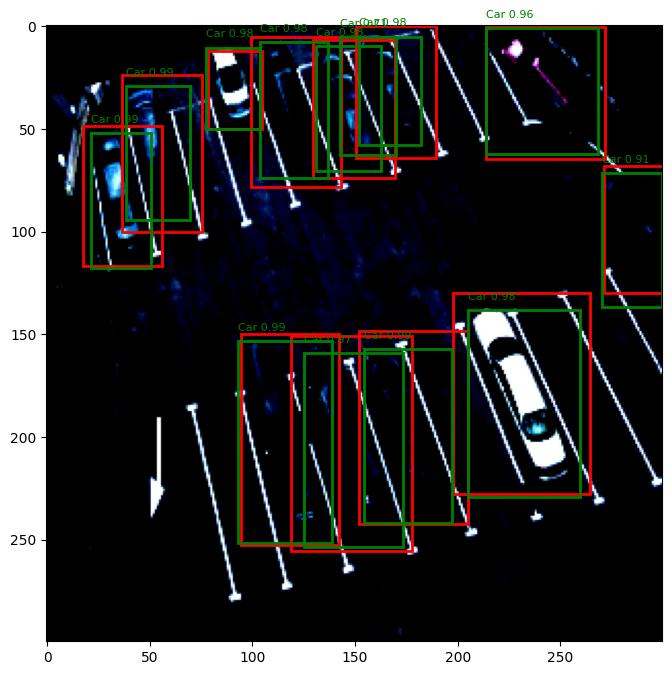

In [216]:
plot_predictions(model_rcnn,images[0], targets[0], rcnn_preds[0], score_thresh=0.5)


In [ ]:
torch.save(model.state_dict(), "mobile_net_car.pth")
torch.save(model_rcnn.state_dict(), "faster_rcnn_car.pth")


# Evalutating the two models (MobileNet and RCNN) based on the MAP 
Initally the bounding boxes prediction for the same image was better in RCNN model, to confirm i used the Mean Average Precision to evaluate the two models 

In [247]:
def evaluate_model(model, loader, device):
    model.eval()
    model.to(device)
    metric = MeanAveragePrecision()
    
    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)  
            metric.update(preds, targets)

    return metric.compute()

In [249]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("MobileNet SSD evaluation")
ssd_results = evaluate_model(model, val_loader, device)
print(ssd_results)


MobileNet SSD evaluation
{'map': tensor(0.1461), 'map_50': tensor(0.3330), 'map_75': tensor(0.1056), 'map_small': tensor(0.0394), 'map_medium': tensor(0.3636), 'map_large': tensor(0.2639), 'mar_1': tensor(0.0174), 'mar_10': tensor(0.1344), 'mar_100': tensor(0.2770), 'mar_small': tensor(0.1652), 'mar_medium': tensor(0.5445), 'mar_large': tensor(0.7333), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}


In [250]:
print("Faster R-CNN evaluation")
rcnn_results = evaluate_model(model_rcnn, val_loader, device)
print(rcnn_results)

Faster R-CNN evaluation
{'map': tensor(0.2980), 'map_50': tensor(0.6264), 'map_75': tensor(0.2478), 'map_small': tensor(0.2457), 'map_medium': tensor(0.4239), 'map_large': tensor(0.7337), 'mar_1': tensor(0.0213), 'mar_10': tensor(0.1816), 'mar_100': tensor(0.4211), 'mar_small': tensor(0.3542), 'mar_medium': tensor(0.5810), 'mar_large': tensor(0.7333), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(1, dtype=torch.int32)}


**MobileNet-SSD**

- mAP (0.5:0.95): 0.146 → relatively weak overall accuracy

- mAP@0.5: 0.333 → moderate detection at a loose IoU threshold

- Recall (mAR@100): 0.277 → missed many objects, weaker coverage


**Faster R-CNN**

- mAP (0.5:0.95): 0.298 → ~2× higher than SSD

- mAP@0.5: 0.626 → strong accuracy at IoU=0.5

- Recall (mAR@100): 0.421 → captures significantly more objects